In [1]:
import os
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.models import load_model


In [2]:
# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
VAL_IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "val")
VAL_LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "val")

# Constants
LIMIT_IMAGES = 1000 # Number of images to sample
MAX_PIXELS = 100000  # Max number of pixels to process
LABEL_ID = 7  # Road label
BATCH_SIZE = 32 # Patch size
TARGET_SIZE = 256 # size of resample image width


In [3]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [4]:
def load_images_from_folder(images_dir, labels_dir):
    image_paths = []
    label_paths = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"): 
            image_paths.append(os.path.join(images_dir, filename))
            label_paths.append(os.path.join(labels_dir, filename.replace("leftImg8bit", "gtFine").replace(".png", "_label.png")))
    
    return image_paths, label_paths

In [5]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [22]:
import cv2
import numpy as np
import os
import tqdm

def image_label_generator(image_label_pairs, target_size=TARGET_SIZE, label_id=LABEL_ID, batch_size=BATCH_SIZE):
    """
    A generator that yields batches of resized images and their corresponding labels for training.

    Args:
        image_label_pairs: List of (image_path, label_path) tuples.
        TARGET_SIZE: Fixed width for resizing images, height will be calculated based on the aspect ratio.
        label_id: The label ID for the target class (e.g., road class in segmentation).
        batch_size: Number of samples to return in each batch.

    Yields:
        A tuple (X_batch, y_batch), where X_batch is a batch of images and y_batch is the corresponding batch of labels.
    """
    while True:  # Keep generating images indefinitely
        X_batch = []  # List to store images in the current batch
        y_batch = []  # List to store labels in the current batch
        
        for image_path, label_path in tqdm.tqdm(image_label_pairs):
            # Read and resize the image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            h, w = image.shape[:2]

            # Calculate new height based on aspect ratio
            target_height = int((target_size / w) * h)

            # Resize the image
            image_resized = cv2.resize(image, (target_size, target_height))
            X_batch.append(image_resized)

            # Read and resize the label image
            label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
            label_resized = cv2.resize(label_img, (target_size, target_height), interpolation=cv2.INTER_NEAREST)

            # Convert label to binary mask (for the target class)
            binary_label = (label_resized == label_id).astype(np.uint8)
            y_batch.append(binary_label)

            # If the batch size is met, yield the batch and reset the batch lists
            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)
                X_batch = []
                y_batch = []

        # If any remaining samples in the batch (less than batch_size), yield them
        if len(X_batch) > 0:
            yield np.array(X_batch), np.expand_dims(np.array(y_batch), axis=-1)


In [23]:
def extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE):
    
    # Get training and validation image-label pairs
    train_image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
    val_image_label_pairs = get_image_label_pairs(VAL_IMAGES_DIR, VAL_LABELS_DIR)

    # Create generators for both training and validation data
    train_generator = image_label_generator(
        train_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )
    
    val_generator = image_label_generator(
        val_image_label_pairs, 
        target_size=TARGET_SIZE, 
        label_id=LABEL_ID, 
        batch_size=batch_size
    )

    # This will just return the generators as we will use them for training
    return train_generator, val_generator


In [24]:
STEPS_PER_EPOCH = 1000

train_generator, val_generator = extract_train_val_data_from_generator(target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

def conv_block(input_tensor, num_filters):
    """
    Creates a convolutional block with two convolutional layers followed by ReLU activation.

    Args:
        input_tensor: Input tensor to the block.
        num_filters: Number of filters for the convolutional layers.

    Returns:
        The output tensor of the block.
    """
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    return x

def build_unet_old(input_shape):
    """
    Builds a U-Net model for semantic segmentation.

    Args:
        input_shape: Tuple representing the shape of input images (height, width, channels).

    Returns:
        A compiled U-Net model.
    """
    inputs = layers.Input(shape=input_shape)

    # Contracting Path
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 1024)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    print(f"Shape of u6: {u6.shape}, Shape of c4: {c4.shape}")
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    print(f"Shape of u7: {u7.shape}, Shape of c3: {c3.shape}")
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    print(f"Shape of u8: {u8.shape}, Shape of c2: {c2.shape}")
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    print(f"Shape of u9: {u9.shape}, Shape of c1: {c1.shape}")
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    # Model
    model = Model(inputs, outputs)
    
    # Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=BinaryCrossentropy(), 
                  metrics=[Accuracy()])

    return model

In [32]:
def build_unet(input_shape):
    input_layer = layers.Input(input_shape, name='input')
    x = layers.Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x1 =x
    x = layers.MaxPooling2D(2)(x)
    x = layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x2 = x
    x = layers.MaxPooling2D(2)(x)
    x = layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    print(x.shape)
    print(x2.shape)
    x = layers.Concatenate()([x,x2]) # Skip connections
    x = layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Concatenate()([x,x1]) # Skip connections
    x = layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    model = Model(input_layer, x)

    model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(from_logits=False), 
              metrics=[Accuracy()])
    return model

In [10]:
#model = load_model('model_fcn.keras')

In [ ]:
from tensorflow.keras import optimizers, callbacks

# Assuming `build_unet` is a function that builds your unet model.
# Make sure you have this function implemented somewhere in your code.
def train_image_classifier_with_generator(train_generator, val_generator, steps_per_epoch, validation_steps, epochs=20):
    """
    Train a U-Net model using image and label generators.

    Args:
        train_generator: Generator providing training data batches.
        val_generator: Generator providing validation data batches.
        steps_per_epoch: Number of batches per training epoch.
        validation_steps: Number of batches for validation per epoch.
        epochs: Total number of training epochs.

    Returns:
        model: Trained Keras model.
        history: Training history object.
    """
    # Define the U-Net input shape
    input_shape = (TARGET_SIZE, int(TARGET_SIZE/2), 3)

    # Build the U-Net model
    model = build_unet(input_shape)
    model.summary()
    # Define callbacks
    checkpoint_cb = callbacks.ModelCheckpoint(
        "image_classifier_best.keras", save_best_only=True, monitor="val_loss", mode="min"
    )
    early_stopping_cb = callbacks.EarlyStopping(
        patience=3, restore_best_weights=True, monitor="val_loss", mode="min"
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )

    return model, history

# Example usage
EPOCHS = 20
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 10

model, history = train_image_classifier_with_generator(
    train_generator, 
    val_generator, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    validation_steps=VALIDATION_STEPS, 
    epochs=EPOCHS
)

# Summarize the model
model.summary()



(None, 128, 64, 32)
(None, 128, 64, 16)
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_231 (Conv2D)            (None, 256, 128, 4)  112         ['input[0][0]']                  
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 256, 128, 4)  16         ['conv2d_231[0][0]']             
 rmalization)                                                                                     
                                                   

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'model_13/concatenate_50/concat' defined at (most recent call last):
    File "c:\Users\miror\.conda\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\miror\.conda\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\miror\.conda\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\miror\.conda\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\miror\.conda\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\miror\AppData\Local\Temp\ipykernel_24012\3549699999.py", line 52, in <module>
      model, history = train_image_classifier_with_generator(
    File "C:\Users\miror\AppData\Local\Temp\ipykernel_24012\3549699999.py", line 35, in train_image_classifier_with_generator
      history = model.fit(
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\layers\merging\base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\layers\merging\concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "c:\Users\miror\.conda\envs\tf\lib\site-packages\keras\backend.py", line 3572, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model_13/concatenate_50/concat'
ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [32,128,64,32] vs. shape[1] = [32,64,128,16]
	 [[{{node model_13/concatenate_50/concat}}]] [Op:__inference_train_function_40997]

In [ ]:
model.save('model_fcn.keras')

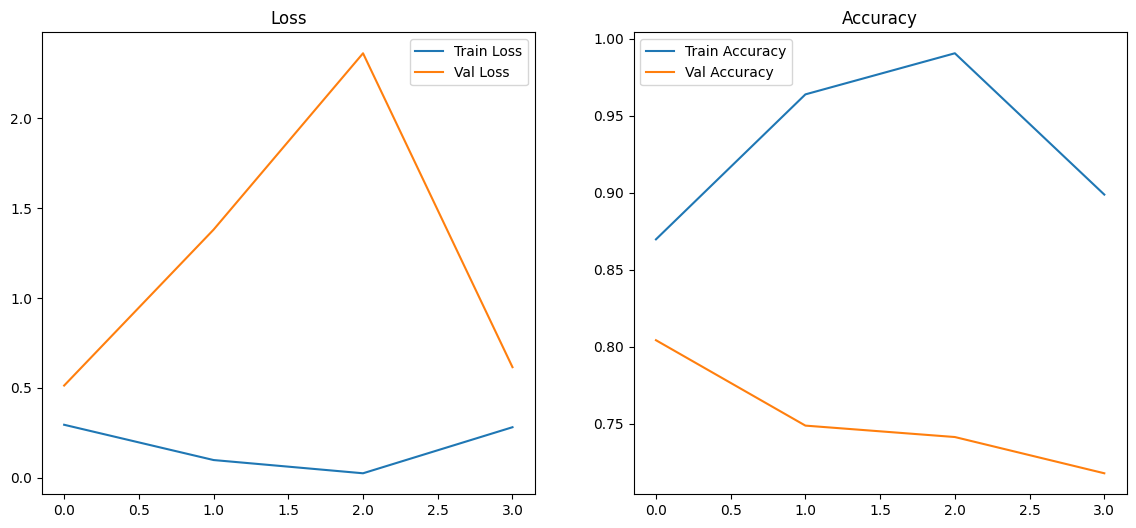

In [ ]:
# make the plot of the loss and accuracy
def plot_loss_accuracy(history):
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_loss_accuracy(history)

100%|██████████| 10/10 [00:00<00:00, 26.96it/s]


1/1 [==============================] - 0s 130ms/step


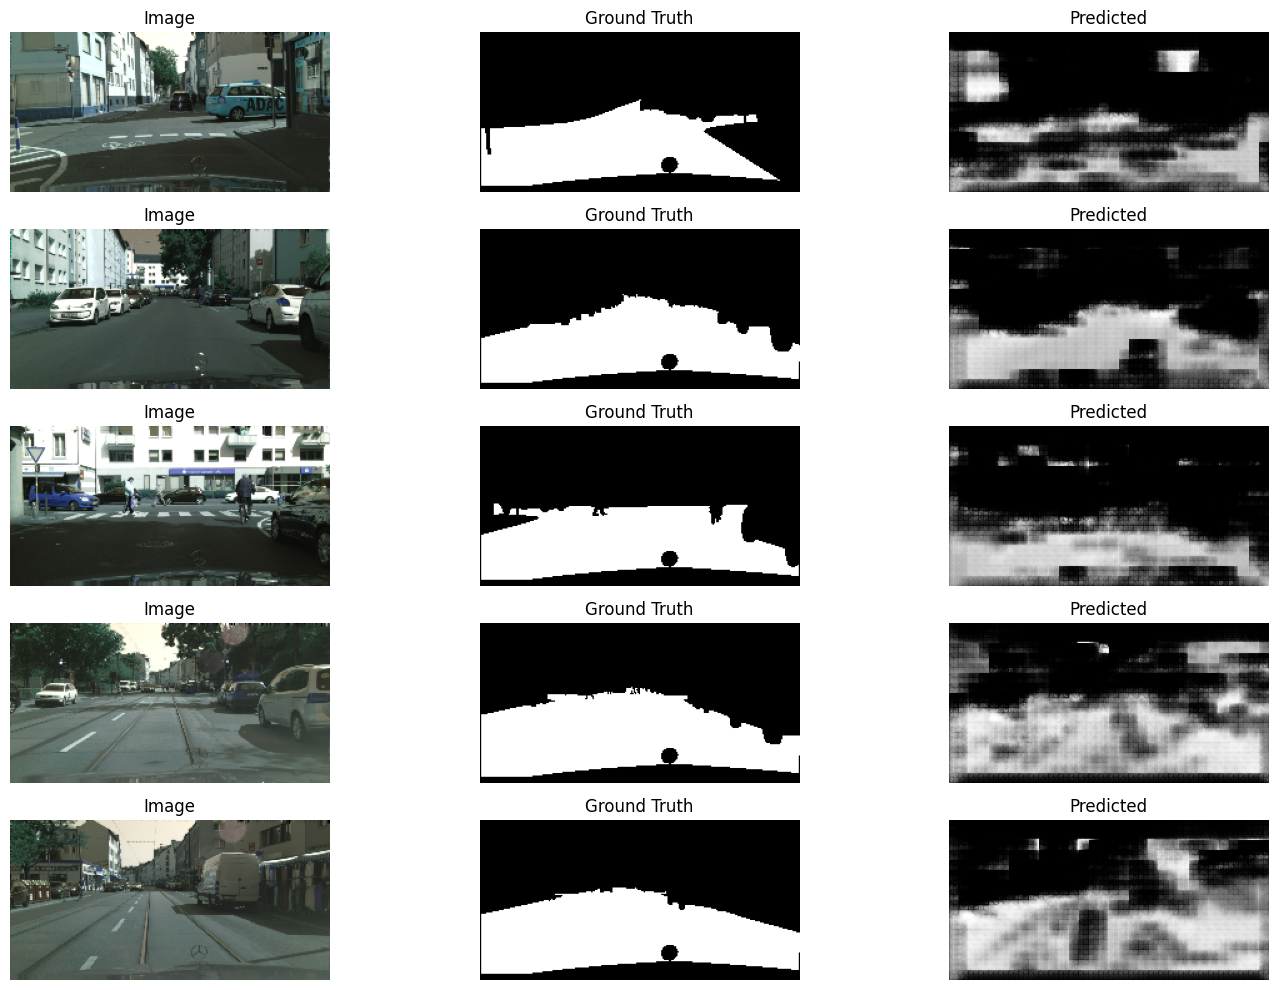

In [ ]:
# geenrate the x_val from the genertaor funciotn, a good amoint of data to test the model
X_val, y_val = next(val_generator)

# Predict on the validation data
y_pred = model.predict(X_val)

def plot_images(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3*i + 1)
        plt.imshow(X[i].astype(np.uint8))
        plt.axis('off')
        plt.title("Image")

        plt.subplot(num_images, 3, 3*i + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")

        plt.subplot(num_images, 3, 3*i + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Predicted")

    plt.tight_layout()
    plt.show()

plot_images(X_val, y_val, y_pred)

100%|██████████| 10/10 [00:00<00:00, 25.92it/s]


1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.79      0.94      0.86    208100
           1       0.84      0.57      0.68    119580

    accuracy                           0.80    327680
   macro avg       0.82      0.75      0.77    327680
weighted avg       0.81      0.80      0.79    327680



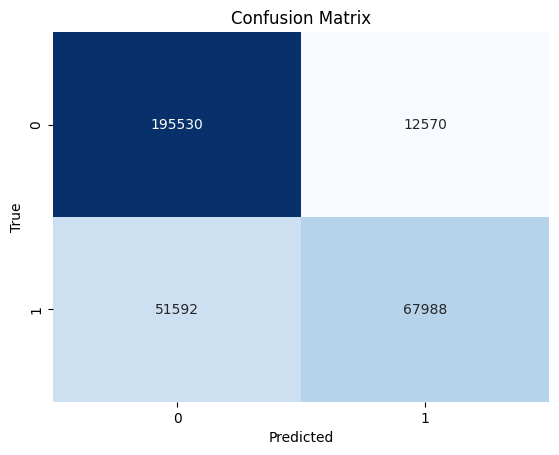

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
X_val, y_val = next(val_generator)

# Predict on the validation data
y_pred = model.predict(X_val)
# Convert the binary predictions to boolean
y_pred_bool = y_pred > 0.5
# Reshape the ground truth to match the predictions
y_val = y_val.reshape(y_pred.shape)

# Calculate the confusion matrix
cm = confusion_matrix(y_val.ravel(), y_pred_bool.ravel())

print(classification_report(y_val.ravel(), y_pred_bool.ravel()))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()